<a href="https://colab.research.google.com/github/ConstDobrovol/FU_CV/blob/master/%D0%9C%D0%97_%D0%94%D0%BE%D0%B1%D1%80%D0%BE%D0%B2%D0%BE%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%9B%D0%B0%D0%B13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Лабораторная работа №3: Нейросетевые классификаторы изображений**

In [ ]:
import tensorflow as tf # библиотека для машинного обучения и глубокого обучения
import matplotlib.pyplot as plt # библиотека для визуализации данных в Python
import numpy as np #  библиотека для работы с многомерными массивами и матрицами

In [ ]:
from sklearn import svm # библиотека для машинного обучения на Python
from sklearn.metrics import accuracy_score # модуль предоставляет функции для оценки качества моделей машинного обучения
from sklearn.preprocessing import StandardScaler # используется для стандартизации признаков, чтобы они имели среднее значение 0 и стандартное отклонение 1
from sklearn.model_selection import train_test_split # функция используется для разделения данных на две части: одну для обучения модели, а другую для ее тестирования
from sklearn.preprocessing import OneHotEncoder # используется для преобразования категориальных переменных в числовой формат
from sklearn.model_selection import KFold # используется для реализации k-кратной перекрестной проверки (k-fold cross-validation)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Загрузка набора данных CIFAR-10
cifar10 = tf.keras.datasets.cifar10

# Разделение на обучающую и тестовую выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


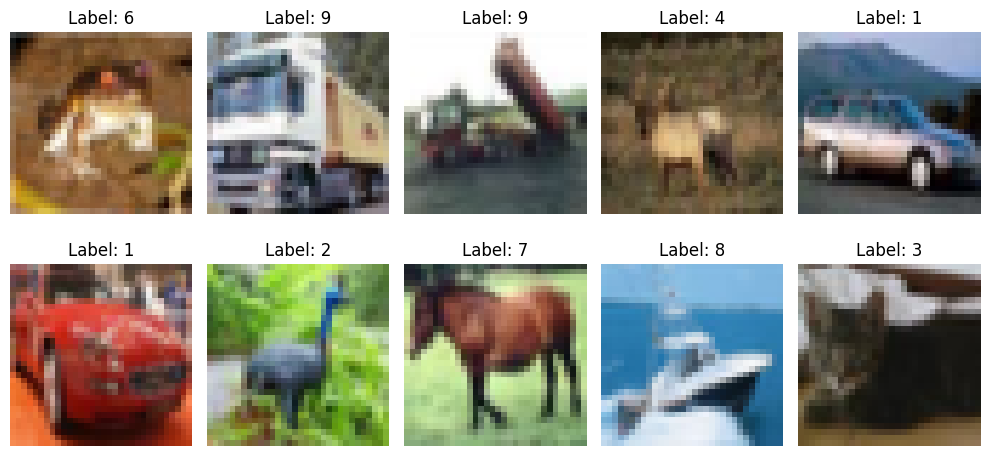

In [ ]:
# Определяем количество изображений для отображения
num_images = 10

# Создаем фигуру для отображения изображений
plt.figure(figsize=(10, 5))

for i in range(num_images):
    plt.subplot(2, 5, i + 1)  # 2 строки и 5 столбцов
    plt.imshow(x_train[i])     # Отображаем изображение
    plt.title(f'Label: {y_train[i][0]}')  # Заголовок с меткой
    plt.axis('off')            # Отключаем оси

plt.tight_layout()
plt.show()

In [ ]:
# Определяем размер выборки
train_size = int(0.1 * len(x_train)) # 10% обучающей выборки
test_size = int(0.1 * len(x_test)) # 10% тестовой выборки

# Случайный выбор 10% данных
indices_train = np.random.choice(len(x_train), train_size, replace=False)
indices_test = np.random.choice(len(x_test), test_size, replace=False)

# Создаем подвыборки на основе случайно выбранных индексов
x_train_subset = x_train[indices_train] # Подмножество изображений для обучения
y_train_subset = y_train[indices_train] # Подмножество меток для обучения
x_test_subset = x_test[indices_test] # Подмножество изображений для тестирования
y_test_subset = y_test[indices_test] # Подмножество меток для тестирования

# Теперь можно использовать x_train_subset, y_train_subset, x_test_subset и y_test_subset

In [ ]:
# Преобразуем метки в одномерный массив (изначально они имеют форму (N, 1))
y_train_subset = y_train_subset.flatten()
y_test_subset = y_test_subset.flatten()

In [ ]:
# Нормализация данных (приведение значений пикселей к диапазону [0, 1]) и преобразование в 2D массив (количество образцов, количество признаков)
x_train_subset = x_train_subset.astype('float32') / 255.0
x_test_subset = x_test_subset.astype('float32') / 255.0

In [ ]:
# Изменим форму данных на (число образцов, 32*32*3), чтобы использовать их в SVM
x_train_subset = x_train_subset.reshape(-1, 32 * 32 * 3)
x_test_subset = x_test_subset.reshape(-1, 32 * 32 * 3)

In [ ]:
# Стандартизация данных (приведение к нулевому среднему и единичной дисперсии)
scaler = StandardScaler() # Создаем экземпляр StandardScaler
x_train_subset = scaler.fit_transform(x_train_subset) # Обучаем скейлер и трансформируем обучающие данные
x_test_subset = scaler.transform(x_test_subset) # Трансформируем тестовые данные с использованием обученного скейлера

SVM классификатор

In [ ]:
# Обучение SVM классификатора с hinge loss (линейное ядро)
clf = svm.SVC(kernel='linear', C=1.0)  # Создаем классификатор SVM с линейным ядром и параметром регуляризации C=1.0
clf.fit(x_train_subset, y_train_subset) # Обучаем модель на подвыборке данных

SVC(kernel='linear')

In [ ]:
# Предсказание на тестовой выборке
y_pred = clf.predict(x_test_subset)

In [ ]:
# Оценка точности классификации
accuracy = accuracy_score(y_test_subset, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 30.00%


 Softmax классификатор

In [ ]:
# Реализация Softmax классификатора
class SoftmaxClassifier:
    def __init__(self, learning_rate=0.01, num_iterations=1000, reg_lambda=0.0):
        # Инициализация гиперпараметров: скорость обучения, количество итераций, регуляризация
        self.learning_rate = learning_rate # Скорость обучения
        self.num_iterations = num_iterations # Количество итераций для обучения
        self.reg_lambda = reg_lambda  # Параметр регуляризации

    def softmax(self, scores):
        # Вычисление вероятностей классов с помощью функции softmax
        exp_scores = np.exp(scores - np.max(scores, axis=1, keepdims=True)) # Вычисляем экспоненты оценок
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # Нормализуем для получения вероятностей

    def compute_loss(self, y_true, y_pred):
        # Вычисление потерь (loss) с учетом регуляризации
        num_examples = y_true.shape[0] # Получаем количество примеров
        log_probs = -np.log(y_pred[range(num_examples), np.argmax(y_true, axis=1)]) # Вычисляем логарифмические вероятности
        data_loss = np.sum(log_probs) / num_examples # Средняя потеря по данным
        reg_loss = 0.5 * self.reg_lambda * np.sum(self.W ** 2)  # Регуляризационная потеря
        return data_loss + reg_loss # Общая потеря

    def fit(self, X, y):
        # Обучение модели на данных X и метках y
        num_examples, num_features = X.shape # Получаем размеры выборки и количество признаков
        num_classes = y.shape[1] # Получаем количество классов

        # Инициализация весов
        self.W = 0.01 * np.random.randn(num_features, num_classes)

        for i in range(self.num_iterations):
            # Вычисление оценок и вероятностей классов
            scores = X.dot(self.W) # Вычисляем оценки классов
            y_pred = self.softmax(scores) # Применяем softmax для получения вероятностей

            # Вычисление градиента
            delta = y_pred - y # Разница между предсказанными и истинными метками
            dW = X.T.dot(delta) / num_examples + self.reg_lambda * self.W # Градиент весов с учетом регуляризации

            # Обновление весов с помощью градиентного спуска
            self.W -= self.learning_rate * dW

    def predict(self, X):
        # Прогнозирование классов для новых данных X
        scores = X.dot(self.W)  # Вычисляем оценки классов
        y_pred = self.softmax(scores)  # Применяем softmax для получения вероятностей
        return np.argmax(y_pred, axis=1) # Возвращаем индекс класса с максимальной вероятностью

In [ ]:
# Преобразование меток в формат one-hot encoding
encoder = OneHotEncoder(sparse_output=False) # Создаем экземпляр OneHotEncoder
y_train_one_hot = encoder.fit_transform(y_train_subset.reshape(-1, 1)) # Преобразуем обучающие метки в one-hot формат
y_test_one_hot = encoder.transform(y_test_subset.reshape(-1, 1)) # Преобразуем тестовые метки в one-hot формат
# Преобразование меток в формат one-hot encoding используется для представления категориальных данных в числовом формате

In [ ]:
# Создание экземпляра классификатора с заданными гиперпараметрами
classifier = SoftmaxClassifier(learning_rate=0.01, num_iterations=1000, reg_lambda=0.1)

# Обучение модели
classifier.fit(x_train_subset, y_train_one_hot)

# Прогнозирование на тестовой выборке
y_pred = classifier.predict(x_test_subset)

# Оценка точности классификации
test_accuracy = accuracy_score(y_test_subset, y_pred)
print(f'Точность на тестовой выборке: {test_accuracy:.4f}')

Кросс-валидация

In [ ]:
# Функция для кросс-валидации с целью подбора оптимального параметра регуляризации.
def cross_validate(X, y, learning_rate=0.01, num_iterations=1000, reg_lambdas=[0.0], k_folds=5):
    kf = KFold(n_splits=k_folds)  # Инициализация KFold для разбиения данных на k фолдов.
    best_lambda = None   # Переменная для хранения лучшего значения регуляризации.
    best_accuracy = 0  # Переменная для хранения лучшей точности.

    for reg_lambda in reg_lambdas: # Перебор значений регуляризации из списка.
        accuracies = [] # Список для хранения точностей для каждого фолда.

        for train_index, val_index in kf.split(X): # Разделение данных на обучающую и валидационную выборки.
            X_train, X_val = X[train_index], X[val_index]  # Обучающая и валидационная выборки.
            y_train, y_val = y[train_index], y[val_index] # Соответствующие метки классов.

            # Создание экземпляра классификатора с заданными параметрами.
            classifier = SoftmaxClassifier(learning_rate=learning_rate, num_iterations=num_iterations, reg_lambda=reg_lambda)
            classifier.fit(X_train, y_train) # Обучение классификатора на обучающей выборке.
            y_val_pred = classifier.predict(X_val) # Прогнозирование меток для валидационной выборки.

            accuracy = accuracy_score(np.argmax(y_val, axis=1), y_val_pred) # Вычисление точности на валидационной выборке.
            accuracies.append(accuracy) # Добавление точности в список.

        mean_accuracy = np.mean(accuracies) # Вычисление средней точности по всем фолдам.
        print(f'Регуляризация: {reg_lambda}, Средняя точность: {mean_accuracy:.4f}')

        if mean_accuracy > best_accuracy: # Проверка, является ли текущая точность лучшей.
            best_accuracy = mean_accuracy # Обновление лучшей точности.
            best_lambda = reg_lambda # Обновление лучшей точности.

    return best_lambda

In [ ]:
# Подбор оптимального параметра регуляризации
reg_lambdas = [0.0, 0.01, 0.1, 1.0, 10.0] # Список значений для регуляризации.
optimal_lambda = cross_validate(x_train_subset, y_train_one_hot, learning_rate=0.01, num_iterations=100, reg_lambdas=reg_lambdas)
# Вызов функции кросс-валидации для поиска оптимального параметра регуляризации.

In [ ]:
# Создание экземпляра классификатора с оптимальным параметром регуляризации
classifier = SoftmaxClassifier(learning_rate=0.01, num_iterations=1000, reg_lambda=optimal_lambda)

# Обучение модели
classifier.fit(x_train_subset, y_train_one_hot)

# Прогнозирование на тестовой выборке
y_pred = classifier.predict(x_test_subset)

# Оценка точности классификации
test_accuracy = accuracy_score(np.argmax(y_test_one_hot, axis=1), y_pred) # Вычисление точности на тестовой выборке.
print(f'Точность на тестовой выборке: {test_accuracy:.4f}')

### **Контрольные вопросы:**

1. В чем разница между hinge loss и cross-entropy loss?

2. Как регуляризация влияет на обучение модели?

3. Какие методы оптимизации используются для обучения линейных классификаторов?

4. Почему важно нормализовать данные перед обучением модели?

1. В чем разница между hinge loss и cross-entropy loss?

 Hinge Loss используется в основном для задач классификации с поддержкой векторами (SVM). Cross-Entropy Loss применяется в задачах многоклассовой классификации и обычно используется с функцией активации softmax.

2. Как регуляризация влияет на обучение модели?

Регуляризация помогает предотвратить переобучение модели, добавляя штраф за сложность модели. Она может быть реализована через:

 L1 регуляризация (Lasso): добавляет сумму абсолютных значений коэффициентов к функции потерь, что может привести к разреженности модели (некоторые веса становятся равными нулю).

 L2 регуляризация (Ridge): добавляет сумму квадратов коэффициентов, что помогает уменьшить величину весов, но не приводит к разреженности.

 Регуляризация способствует улучшению обобщающей способности модели, позволяя ей лучше работать на новых, невидимых данных.

3. Какие методы оптимизации используются для обучения линейных классификаторов?

 Градиентный спуск: итеративный метод, который обновляет параметры модели в направлении антиградиента функции потерь.

 Стохастический градиентный спуск (SGD): обновляет параметры на основе одной или нескольких случайно выбранных обучающих примеров, что может ускорить обучение.

 Mini-batch градиентный спуск: комбинирует преимущества батчевого и стохастического градиентного спуска, используя небольшие подмножества данных для обновления параметров.

 Адаптивные методы: такие как Adam, RMSprop и Adagrad, которые адаптируют скорость обучения на основе истории градиентов.

4. Почему важно нормализовать данные перед обучением модели?

Нормализация данных помогает:

 Ускорить сходимость: многие алгоритмы оптимизации, особенно основанные на градиентном спуске, работают лучше и быстрее, когда данные имеют схожий масштаб.

 Избежать доминирования признаков: если признаки имеют разные масштабы, более крупные значения могут преобладать над меньшими, что может исказить результаты обучения.

 Улучшить производительность модели: нормализованные данные могут привести к лучшему качеству предсказаний и более стабильной работе модели.